In [45]:
# import the required libraries
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Build your own convolutional neural network using pytorch

### Dataset loading & preprocessing

In [46]:
# Set base paths
data_dir = "Dog_X_ray/Dog_heart"
test_dir = "Dog_X_ray/Test"

# Define image size (can change later)
IMG_SIZE = 224

# Define label mapping
label_map = {"Small": 0, "Normal": 1, "Large": 2}

#  Transforms
"""train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # optional augmentation
    transforms.ToTensor(),
])"""

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])
"""train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])"""

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])





In [47]:
#  Load Train and Valid using ImageFolder
train_data = datasets.ImageFolder(os.path.join(data_dir, 'Train'), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'Valid'), transform=val_transforms)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

# 3. Custom Dataset for Test Images
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted([
            os.path.join(root_dir, fname) for fname in os.listdir(root_dir)
            if fname.endswith((".png", ".jpg", ".jpeg"))
        ])
        self.image_names = [os.path.basename(p) for p in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_names[idx]  # return image + filename

# Load Test Dataset
test_dataset = TestDataset(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
# Sanity check
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}, Labels: {labels}")
    break  

Batch shape: torch.Size([16, 3, 224, 224]), Labels: tensor([1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1])


##  Defining the CNN architecture

In [49]:
class DogHeartCNN(nn.Module):
    def __init__(self):
        super(DogHeartCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 224x224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 112x112
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 112x112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 56x56
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 56x56
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 28x28
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 28x28
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 14x14
        )
        # 5th block
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 14 -> 7
        )


        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 3)  # 3 classes

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [50]:
# Train model using dog heart dataset 
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = DogHeartCNN().to(device)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Add learning rate scheduler (without verbose)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    best_val_acc = 0.0
    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        val_loss = val_loss / len(val_loader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # Step the scheduler with validation accuracy
        scheduler.step(val_acc)

        # Print current learning rate
        print(f"Current LR: {scheduler.optimizer.param_groups[0]['lr']}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("model saved!")

    print(f"\nValidation Accuracy: {best_val_acc:.4f}")

    # Plot accuracy & loss
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
    plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss_list, label='Train Loss')
    plt.plot(epochs_range, val_loss_list, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Using device: cpu


Epoch 1/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]



Epoch 1/30
Train Loss: 1.4394 | Train Acc: 0.4164
Val   Loss: 0.9996 | Val   Acc: 0.4550
Current LR: 0.0001
model saved!


Epoch 2/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]



Epoch 2/30
Train Loss: 0.9630 | Train Acc: 0.4707
Val   Loss: 0.9539 | Val   Acc: 0.4200
Current LR: 0.0001


Epoch 3/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]



Epoch 3/30
Train Loss: 0.9302 | Train Acc: 0.4686
Val   Loss: 0.8975 | Val   Acc: 0.4600
Current LR: 0.0001
model saved!


Epoch 4/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]



Epoch 4/30
Train Loss: 0.9096 | Train Acc: 0.4914
Val   Loss: 0.9020 | Val   Acc: 0.4900
Current LR: 0.0001
model saved!


Epoch 5/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]



Epoch 5/30
Train Loss: 0.8402 | Train Acc: 0.5407
Val   Loss: 0.8657 | Val   Acc: 0.5200
Current LR: 0.0001
model saved!


Epoch 6/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.65it/s]



Epoch 6/30
Train Loss: 0.8018 | Train Acc: 0.5743
Val   Loss: 0.7790 | Val   Acc: 0.5850
Current LR: 0.0001
model saved!


Epoch 7/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]



Epoch 7/30
Train Loss: 0.7746 | Train Acc: 0.5993
Val   Loss: 0.8602 | Val   Acc: 0.5550
Current LR: 0.0001


Epoch 8/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]



Epoch 8/30
Train Loss: 0.7735 | Train Acc: 0.5914
Val   Loss: 0.7218 | Val   Acc: 0.6450
Current LR: 0.0001
model saved!


Epoch 9/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]



Epoch 9/30
Train Loss: 0.7503 | Train Acc: 0.6036
Val   Loss: 0.7881 | Val   Acc: 0.5950
Current LR: 0.0001


Epoch 10/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]



Epoch 10/30
Train Loss: 0.7344 | Train Acc: 0.6257
Val   Loss: 0.6678 | Val   Acc: 0.6950
Current LR: 0.0001
model saved!


Epoch 11/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]



Epoch 11/30
Train Loss: 0.7332 | Train Acc: 0.6307
Val   Loss: 0.7370 | Val   Acc: 0.6400
Current LR: 0.0001


Epoch 12/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]



Epoch 12/30
Train Loss: 0.7171 | Train Acc: 0.6450
Val   Loss: 0.7393 | Val   Acc: 0.6100
Current LR: 0.0001


Epoch 13/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]



Epoch 13/30
Train Loss: 0.6951 | Train Acc: 0.6564
Val   Loss: 0.8499 | Val   Acc: 0.5300
Current LR: 0.0001


Epoch 14/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]



Epoch 14/30
Train Loss: 0.6926 | Train Acc: 0.6550
Val   Loss: 0.7019 | Val   Acc: 0.6300
Current LR: 5e-05


Epoch 15/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]



Epoch 15/30
Train Loss: 0.6744 | Train Acc: 0.6779
Val   Loss: 0.6441 | Val   Acc: 0.6800
Current LR: 5e-05


Epoch 16/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]



Epoch 16/30
Train Loss: 0.6606 | Train Acc: 0.6693
Val   Loss: 0.6758 | Val   Acc: 0.6350
Current LR: 5e-05


Epoch 17/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]



Epoch 17/30
Train Loss: 0.6538 | Train Acc: 0.6807
Val   Loss: 0.6462 | Val   Acc: 0.6950
Current LR: 5e-05


Epoch 18/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]



Epoch 18/30
Train Loss: 0.6490 | Train Acc: 0.6779
Val   Loss: 0.6418 | Val   Acc: 0.6550
Current LR: 2.5e-05


Epoch 19/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.67it/s]



Epoch 19/30
Train Loss: 0.6275 | Train Acc: 0.6850
Val   Loss: 0.6410 | Val   Acc: 0.6950
Current LR: 2.5e-05


Epoch 20/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]



Epoch 20/30
Train Loss: 0.6196 | Train Acc: 0.7057
Val   Loss: 0.6464 | Val   Acc: 0.6750
Current LR: 2.5e-05


Epoch 21/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]



Epoch 21/30
Train Loss: 0.6250 | Train Acc: 0.6929
Val   Loss: 0.6257 | Val   Acc: 0.6900
Current LR: 2.5e-05


Epoch 22/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]



Epoch 22/30
Train Loss: 0.6216 | Train Acc: 0.7100
Val   Loss: 0.6261 | Val   Acc: 0.7050
Current LR: 2.5e-05
model saved!


Epoch 23/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]



Epoch 23/30
Train Loss: 0.6245 | Train Acc: 0.6914
Val   Loss: 0.6335 | Val   Acc: 0.7100
Current LR: 2.5e-05
model saved!


Epoch 24/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]



Epoch 24/30
Train Loss: 0.6119 | Train Acc: 0.7086
Val   Loss: 0.6363 | Val   Acc: 0.6600
Current LR: 2.5e-05


Epoch 25/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]



Epoch 25/30
Train Loss: 0.6244 | Train Acc: 0.7114
Val   Loss: 0.6275 | Val   Acc: 0.6750
Current LR: 2.5e-05


Epoch 26/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]



Epoch 26/30
Train Loss: 0.6076 | Train Acc: 0.7043
Val   Loss: 0.6230 | Val   Acc: 0.7100
Current LR: 2.5e-05


Epoch 27/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]



Epoch 27/30
Train Loss: 0.5943 | Train Acc: 0.7214
Val   Loss: 0.6251 | Val   Acc: 0.7150
Current LR: 2.5e-05
model saved!


Epoch 28/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]



Epoch 28/30
Train Loss: 0.5834 | Train Acc: 0.7279
Val   Loss: 0.6200 | Val   Acc: 0.6750
Current LR: 2.5e-05


Epoch 29/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]



Epoch 29/30
Train Loss: 0.6022 | Train Acc: 0.7171
Val   Loss: 0.6654 | Val   Acc: 0.6750
Current LR: 2.5e-05


Epoch 30/30 - Validation: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]



Epoch 30/30
Train Loss: 0.6009 | Train Acc: 0.7236
Val   Loss: 0.6401 | Val   Acc: 0.6650
Current LR: 2.5e-05

Validation Accuracy: 0.7150


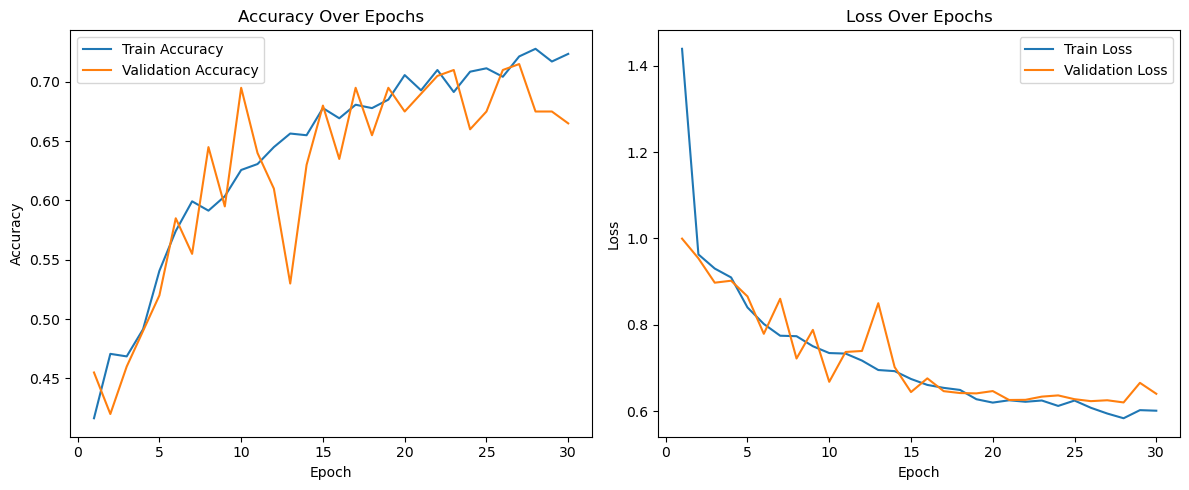

In [51]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30)

###  Generating test predictions

In [41]:
import pandas as pd

def generate_predictions(model_path, test_loader, output_csv="test_predictions.csv"):
    
    #load the model
    model = DogHeartCNN()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    predictions = []
    image_names = []

    with torch.no_grad():
        for images, names in tqdm(test_loader, desc="Generating Predictions"):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            image_names.extend(names)

    # Save csv
    with open(output_csv, "w") as f:
        for name, pred in zip(image_names, predictions):
            f.write(f"{name},{pred}\n")

    print(f"\n Predictions saved to: {output_csv}")


In [42]:
generate_predictions("best_model.pth", test_loader)

Generating Predictions: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


 Predictions saved to: test_predictions.csv


# 3. Evaluate your model using the developed software

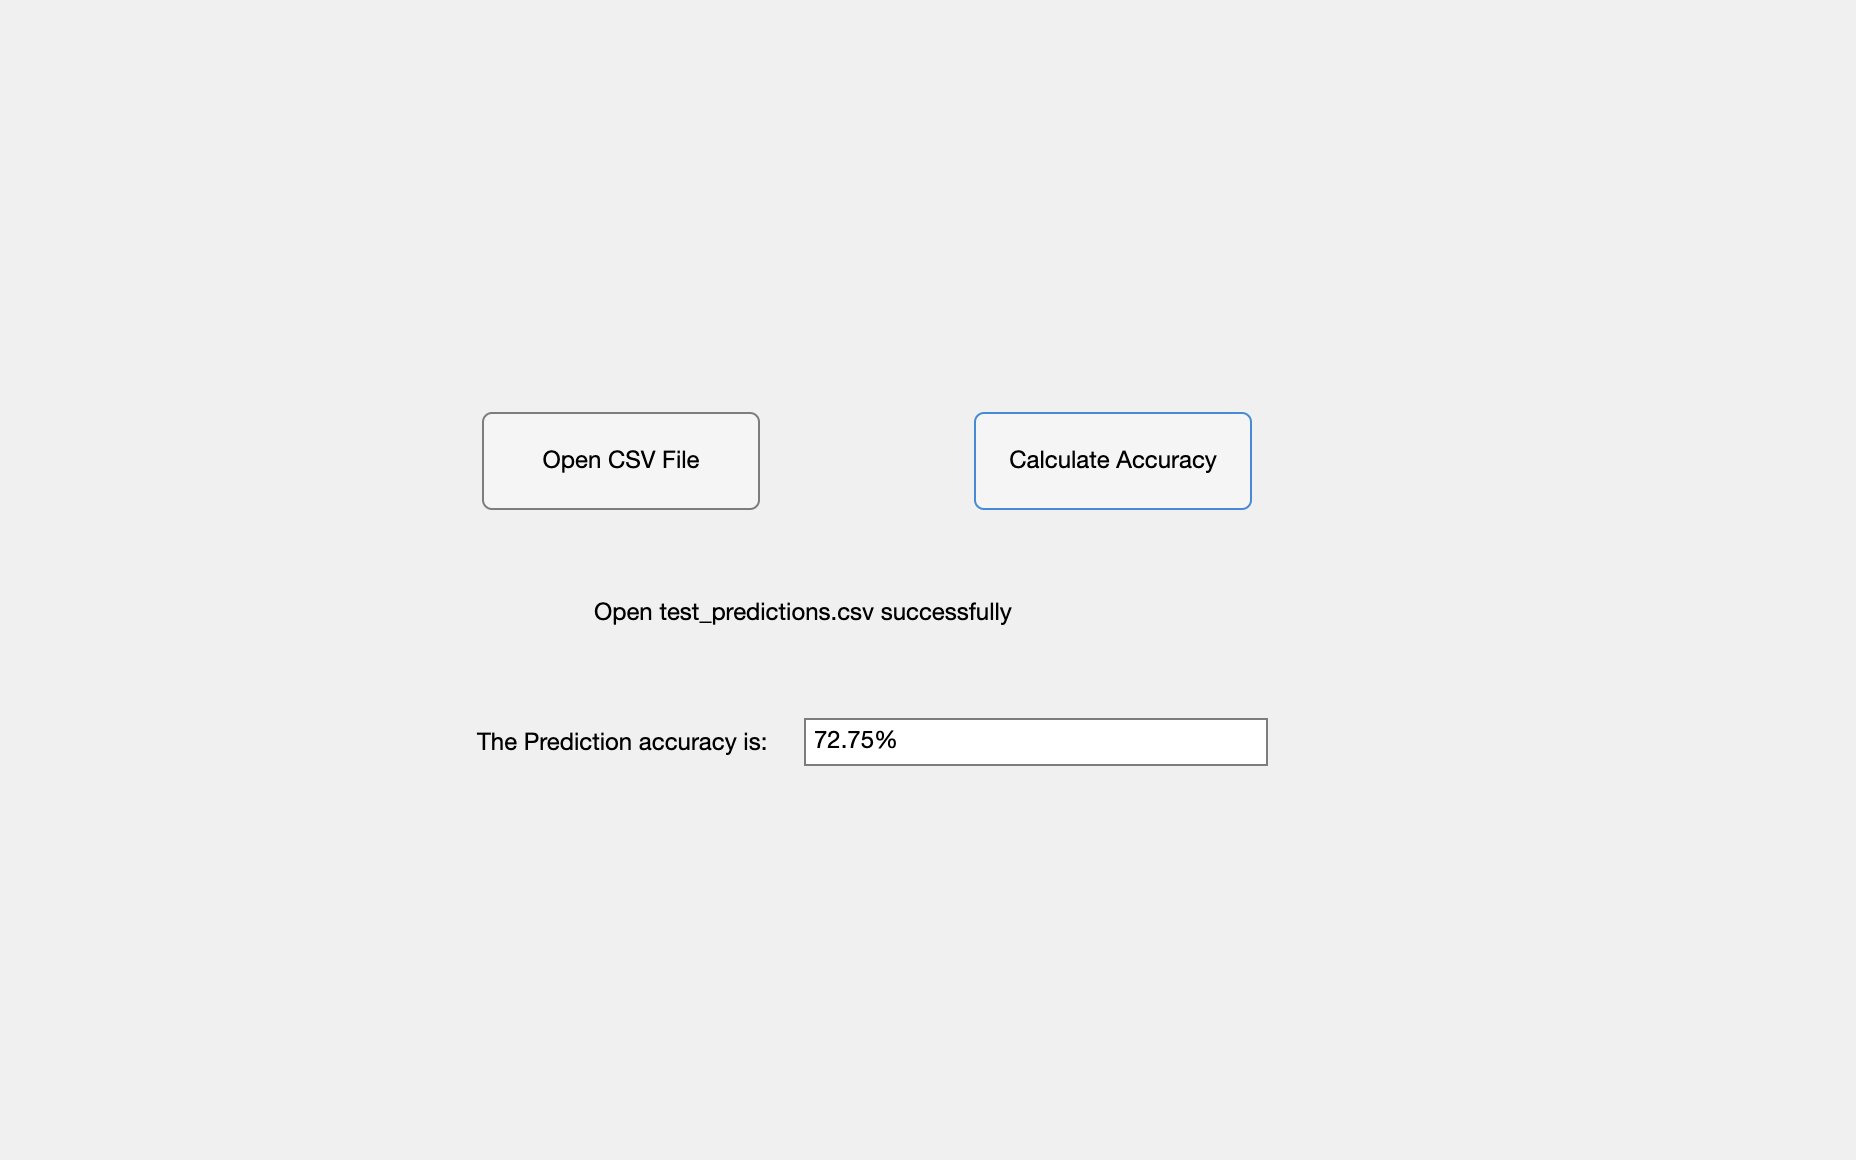

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

In the given paper "Regressive Vision Transformer for Dog Cardiomegaly Assessment", report states that their baseline model, VGG16, gained an overall accuracy of 75% on the dog heart X-ray classification task. This gives as the benchmark for calculating the architectures.

My CNN, trained from scratch, reached the peak accuracy of 72.75%. This outcome does not overshadow the VGG16 performance but is close to it with a significantly lighter architecture involving fewer parameters, as well as no pretrained weights.

The gap in the performance (~2.25%) probably could be neutralized with a bit more tuning, a deeper insight into augmentations, or transfer learning, yet our model shows a strong possibility and is worth being implemented, especially taking into account the constrains on the resources and training.

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 75 % -->10 points
     < 55 % -->0 points
     >= 55 % & < 75% --> 0.5 point/percent
     

(6). Discussion - 10 points